In [1]:
import os
import zipfile
import io
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from skimage.util import montage
from tensorflow.keras.utils import to_categorical
import matplotlib.cm as cm
from math import ceil, sqrt
import nibabel as nib

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [43]:
# Global Constants
patient_id = "56"  # Global for easy changes
ZIP_PATH = "/content/drive/MyDrive/data.zip"  # Path to the ZIP file containing HDF5 data
NIFTI_ZIP_PATH = "/content/drive/MyDrive/369Seg_Masks_nii.zip"  # Path to the ZIP file containing NIfTI masks
IMG_HEIGHT, IMG_WIDTH = 240, 240  # Dimensions of each slice
SLICES = 155  # Total number of slices per patient
# Corrected modality mapping based on actual data characteristics
MODALITIES = ["FLAIR", "T2", "T1ce", "T1"]  # List of imaging modalities
MODALITY_INDICES = {"T1": 3, "T1ce": 2, "T2": 1, "FLAIR": 0}  # Mapping of modalities to their indices
CLASS_LABELS = {0: "Background", 1: "Non-enhancing Tumor", 2: "Edema", 3: "Enhancing Tumor"}  # Labels for segmentation classes
COLORS = {0: "Greys", 1: "Reds", 2: "Greens", 3: "Oranges"}  # Color mappings for visualization

In [44]:
# Efficient NIfTI loading function for full volume from ZIP
def load_nifti_mask_from_zip(zip_ref, nifti_filename):
    try:
        with zip_ref.open(nifti_filename) as file:
            file_data = io.BytesIO(file.read())
            nifti_img = nib.Nifti1Image.from_bytes(file_data.getvalue())
            mask_3d = nifti_img.get_fdata().astype(np.uint8)  # Shape: (240, 240, 155) for axial volume
            return mask_3d
    except Exception as e:
        print(f"Error reading NIfTI file {nifti_filename}: {e}")
        return None

def get_nifti_filename(patient_id):
    patient_num = int(patient_id)
    return f"369Seg_Masks_nii/BraTS20_Training_{patient_num:03d}_seg.nii"

# Read HDF5 from ZIP
def read_hdf5_from_zip(zip_ref, filename):
    try:
        with zip_ref.open(filename) as file:
            file_data = io.BytesIO(file.read())
            with h5py.File(file_data, 'r') as f:
                image = f['image'][:]  # shape: (240, 240, 4)
            return image
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None

# Convert mask to one-hot (4 classes) with NIfTI compatibility
def convert_mask_to_onehot(mask_3d, slice_idx):
    if len(mask_3d.shape) == 3 and mask_3d.shape[0] == IMG_HEIGHT and mask_3d.shape[1] == IMG_WIDTH:
        mask_2d = mask_3d[:, :, slice_idx]
        mask_2d = np.where(mask_2d == 4, 3, mask_2d)  # Remap value 4 to 3
        onehot = to_categorical(mask_2d, num_classes=4)
    else:
        raise ValueError(f"Unexpected mask shape for volume: {mask_3d.shape}")
    return onehot

In [45]:
# Custom montage function for better control
def create_slice_grid(slices, grid_rows=None, grid_cols=None, figsize=(16, 14)):
    """
    Create a grid visualization of brain slices with proper spacing and labels
    """
    n_slices = len(slices)

    if grid_rows is None or grid_cols is None:
        # Calculate optimal grid dimensions
        if n_slices <= 100:
            grid_cols = 10
            grid_rows = ceil(n_slices / grid_cols)
        else:
            grid_cols = 13  # For 155 slices
            grid_rows = ceil(n_slices / grid_cols)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=figsize)

    # Flatten axes array for easier indexing
    if grid_rows == 1:
        axes = [axes] if grid_cols == 1 else axes
    else:
        axes = axes.flatten()

    # Normalize slices for better contrast
    slices_normalized = []
    for slice_img in slices:
        # Normalize each slice individually
        slice_norm = slice_img.copy()
        if slice_norm.max() > slice_norm.min():
            slice_norm = (slice_norm - slice_norm.min()) / (slice_norm.max() - slice_norm.min())
        slices_normalized.append(slice_norm)

    for i in range(grid_rows * grid_cols):
        if i < n_slices:
            axes[i].imshow(slices_normalized[i], cmap='gray', aspect='equal')
            axes[i].set_title(f'Slice {i}', fontsize=8)
            axes[i].axis('off')
        else:
            # Hide empty subplots
            axes[i].axis('off')

    plt.tight_layout()
    return fig

# Visualize using matplotlib subplots for more control
def visualize_all_slices_subplot(slices, title, grid_cols=13):
    """
    Visualize all slices using matplotlib subplots for better control
    """
    n_slices = len(slices)
    grid_rows = ceil(n_slices / grid_cols)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(18, 16))
    axes = axes.flatten() if grid_rows > 1 else [axes] if grid_cols == 1 else axes

    for i in range(grid_rows * grid_cols):
        if i < n_slices:
            # Normalize each slice for better visibility
            slice_data = slices[i].copy()
            if slice_data.max() > slice_data.min():
                slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())

            axes[i].imshow(slice_data, cmap='gray', aspect='equal')
            axes[i].set_title(f'{i}', fontsize=6)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.suptitle(title, fontsize=16, y=0.95)
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    return fig

In [46]:
# Load data
print("Loading slices...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    images = np.zeros((SLICES, IMG_HEIGHT, IMG_WIDTH, 4))  # FLAIR, T2, T1ce, T1
    loaded_count = 0

    for z in range(SLICES):
        filename = f"data/volume_{patient_id}_slice_{z}.h5"
        if filename in zip_ref.namelist():
            image = read_hdf5_from_zip(zip_ref, filename)
            if image is not None:
                images[z] = image
                loaded_count += 1
                print(f"Successfully loaded {filename}")
            else:
                print(f"Failed to load data from {filename}")
        else:
            print(f"Missing: {filename}")

    print(f"Loaded {loaded_count} slices successfully out of {SLICES}!")
    print(f"Image shape: {images.shape}")

    # Load NIfTI mask volume
    with zipfile.ZipFile(NIFTI_ZIP_PATH, 'r') as nifti_zip_ref:
        nifti_filename = get_nifti_filename(patient_id)
        mask_3d = load_nifti_mask_from_zip(nifti_zip_ref, nifti_filename)
        if mask_3d is None:
            raise ValueError(f"Failed to load NIfTI mask for patient {patient_id}")

Loading slices...
Successfully loaded data/volume_56_slice_0.h5
Successfully loaded data/volume_56_slice_1.h5
Successfully loaded data/volume_56_slice_2.h5
Successfully loaded data/volume_56_slice_3.h5
Successfully loaded data/volume_56_slice_4.h5
Successfully loaded data/volume_56_slice_5.h5
Successfully loaded data/volume_56_slice_6.h5
Successfully loaded data/volume_56_slice_7.h5
Successfully loaded data/volume_56_slice_8.h5
Successfully loaded data/volume_56_slice_9.h5
Successfully loaded data/volume_56_slice_10.h5
Successfully loaded data/volume_56_slice_11.h5
Successfully loaded data/volume_56_slice_12.h5
Successfully loaded data/volume_56_slice_13.h5
Successfully loaded data/volume_56_slice_14.h5
Successfully loaded data/volume_56_slice_15.h5
Successfully loaded data/volume_56_slice_16.h5
Successfully loaded data/volume_56_slice_17.h5
Successfully loaded data/volume_56_slice_18.h5
Successfully loaded data/volume_56_slice_19.h5
Successfully loaded data/volume_56_slice_20.h5
Succe

### **Understanding Image Dimensions and Planes**

Medical images in this dataset are **3D scans**, meaning they are made up of **a series of 2D slices stacked together**. Each slice has the same resolution and represents a cross-section of the brain. These 3D scans follow the natural structure of the human body and are divided into **three main planes** used in medical imaging: **axial, coronal, and sagittal**. Each plane provides a unique way of viewing the brain, making it easier to analyze its structure and detect abnormalities.

### **Why Axial is the Best First Step**

The **axial (transverse) plane** is the preferred initial view for brain tumor analysis in the medical domain because it offers a **top-down perspective**, slicing horizontally through the brain to divide it into upper and lower sections. This plane aligns with standard MRI protocols and is critical for detecting abnormalities like tumors and edema, as it captures the full extent of pathology across horizontal layers, making it the gold standard for initial assessment. Axial slicing provides a comprehensive overview of the brain’s anatomy, including cerebral hemispheres and ventricles, enabling systematic evaluation before exploring other planes.

- **Coronal (Frontal) Plane**: Offers a front-facing view, slicing vertically to split the brain into front and back sections. Useful for detailed follow-up analysis of tumor spread but less comprehensive initially.
- **Sagittal (Lateral) Plane**: Provides a side view, slicing vertically to divide left and right halves. Ideal for midline structure evaluation but secondary to axial for broad tumor detection.
This segmentation task prioritizes the axial view for its diagnostic efficiency.

## **Reason for Using HDF5 (155 Slices of 4 Modalities for 369 Patients) and NIfTI Mask Formats**

The dataset includes **HDF5 files with 155 slices per patient across 4 modalities (FLAIR, T2, T1ce, T1)** for 369 patients, providing a rich 3D representation of brain scans. This format is efficient for storing large multi-dimensional arrays, enabling quick access to image data for each axial slice. The **NIfTI mask formats** complement this by offering a standardized, volume-wide representation of segmentation labels (0: Background, 1: Non-enhancing Tumor, 2: Edema, 3: Enhancing Tumor, with 4 remapped to 3) for the same 369 patients. Integrating NIfTI masks ensures consistency and allows validation of segmentation, leveraging NIfTI’s widespread use in medical imaging for precise 3D annotation.

# **1. Display all the slices along one dimension:**

Creating visualization of all 155 T1 slices...


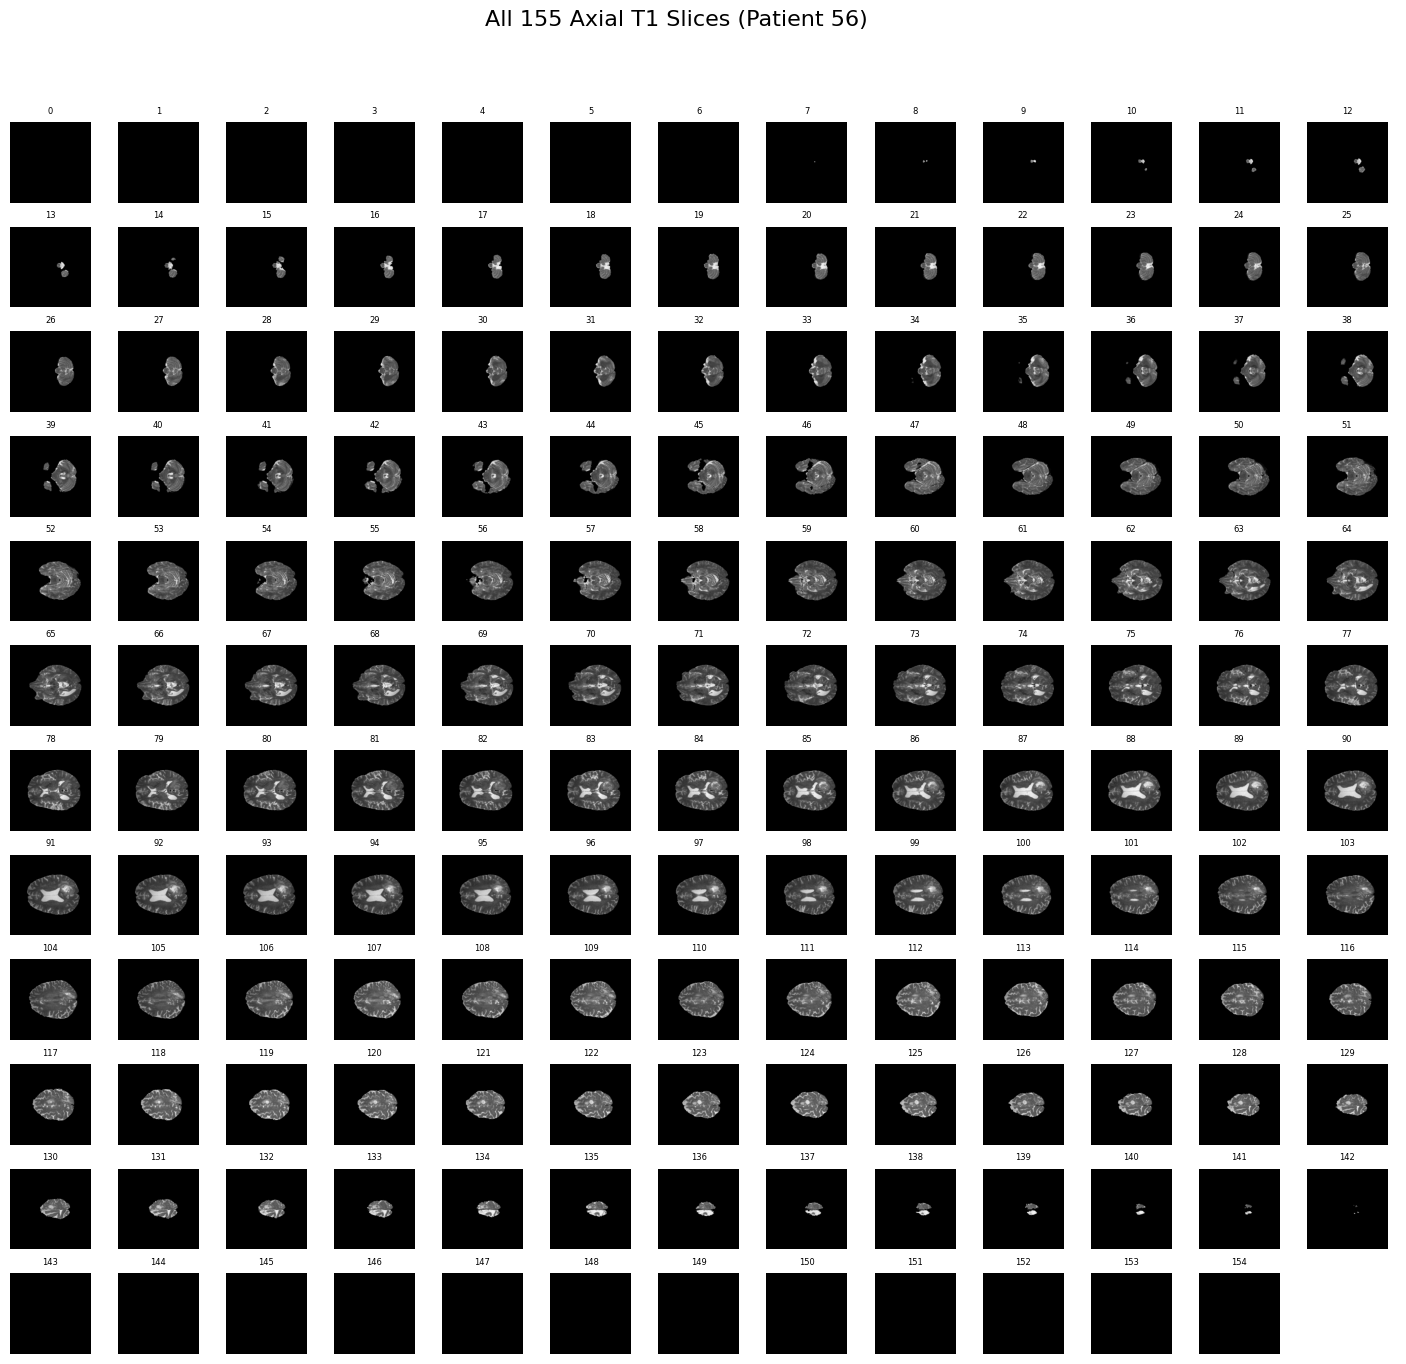

Creating montage visualization...


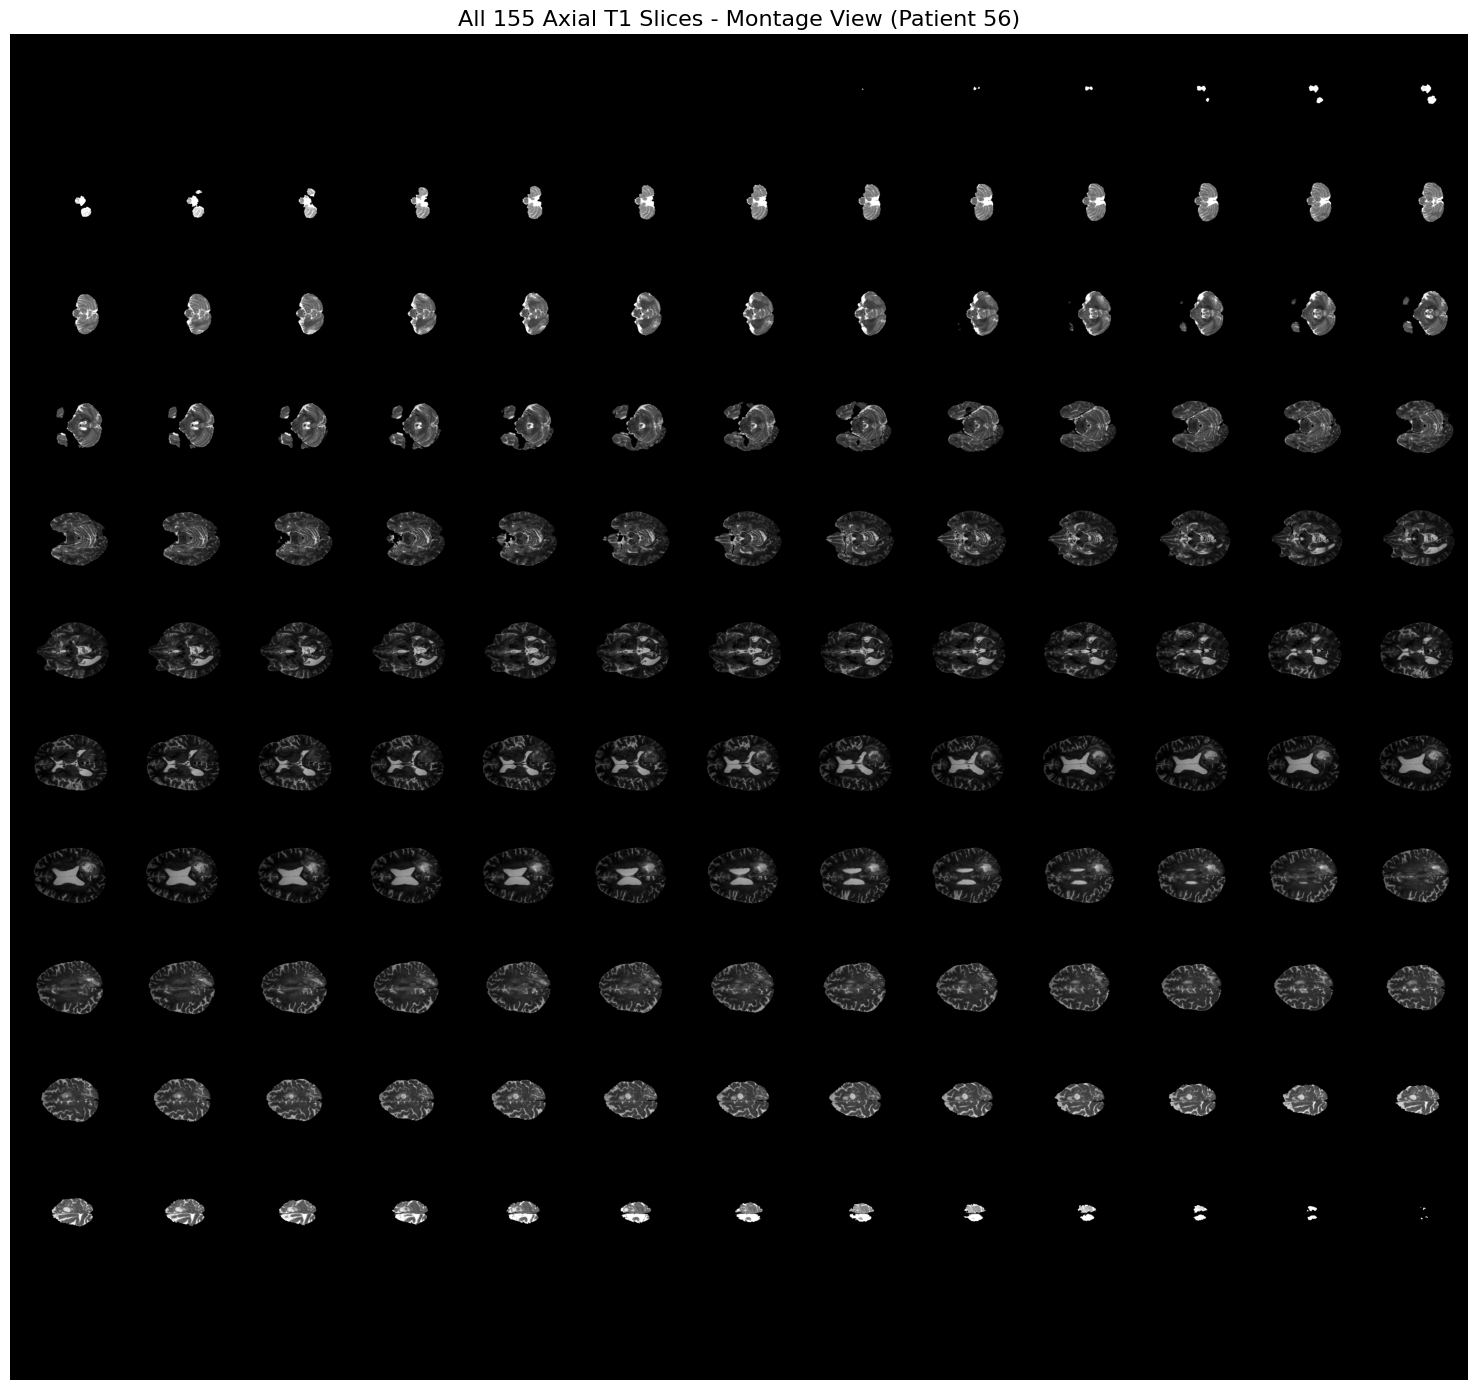

In [47]:
# -----------------------------
# 1. Visualize all 155 T1 slices
print("Creating visualization of all 155 T1 slices...")
t1_slices = images[:, :, :, MODALITY_INDICES["T1"]]  # Index for T1

# Method 1: Using custom subplot function
fig1 = visualize_all_slices_subplot(t1_slices, f"All 155 Axial T1 Slices (Patient {patient_id})", grid_cols=13)
plt.show()

# Method 2: Using skimage montage with better parameters
print("Creating montage visualization...")
plt.figure(figsize=(16, 14))

# Normalize the entire volume first
t1_normalized = t1_slices.copy()
# Global normalization
global_min, global_max = np.percentile(t1_normalized[t1_normalized > 0], [1, 99])
t1_normalized = np.clip(t1_normalized, global_min, global_max)
t1_normalized = (t1_normalized - global_min) / (global_max - global_min)

try:
    t1_grid = montage(t1_normalized, grid_shape=(12, 13), channel_axis=None, fill=0)
    plt.imshow(t1_grid, cmap='gray', aspect='equal')
    plt.title(f"All 155 Axial T1 Slices - Montage View (Patient {patient_id})", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Montage error: {e}")
    print("Using alternative visualization...")

These black parts correspond to a large portion of the slices that do not contain much information, which is expected as the slices progressively represent the brain from one end to the other. These redundant slices, primarily at the beginning and end, capture areas outside the brain or outermost regions with minimal anatomical details, making them less useful for analysis.


Identifying non-redundant slices...
Found 136 non-redundant slices out of 155
Non-redundant slice indices: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]...[133, 134, 135, 136, 137, 138, 139, 140, 141, 142]


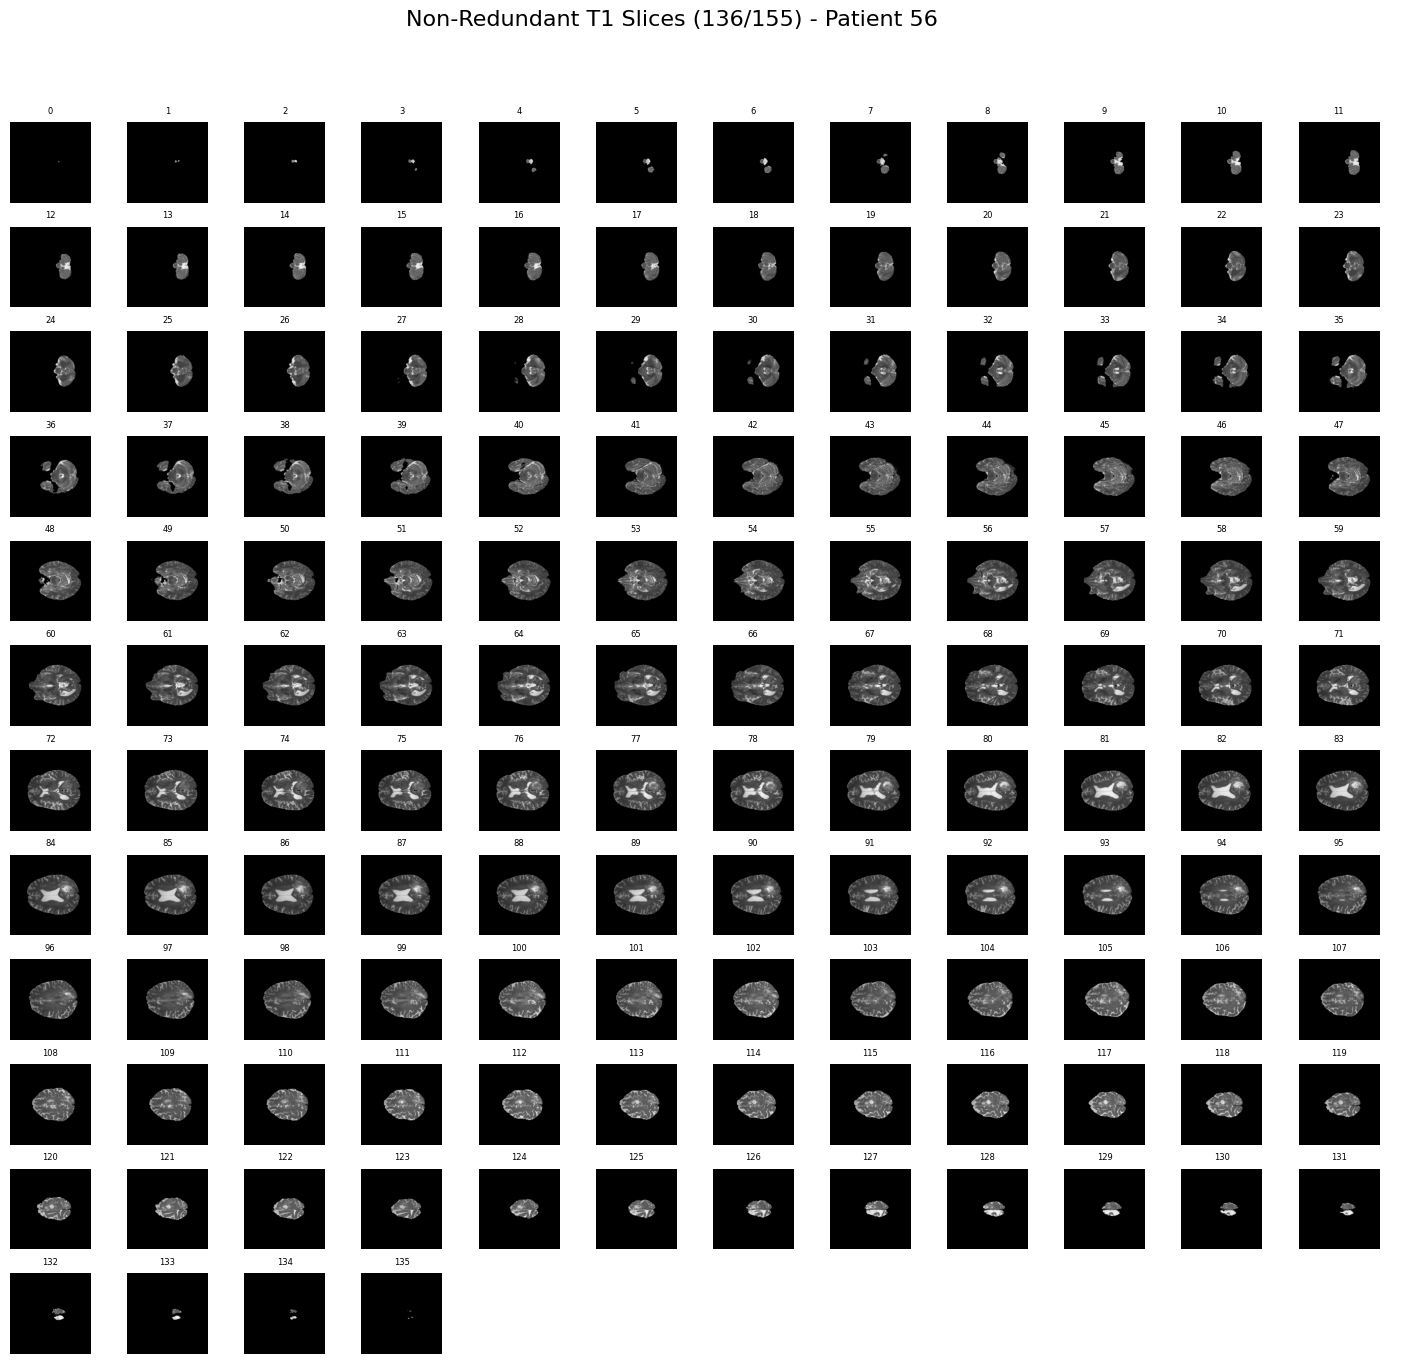

Creating mask montage for non-redundant slices...


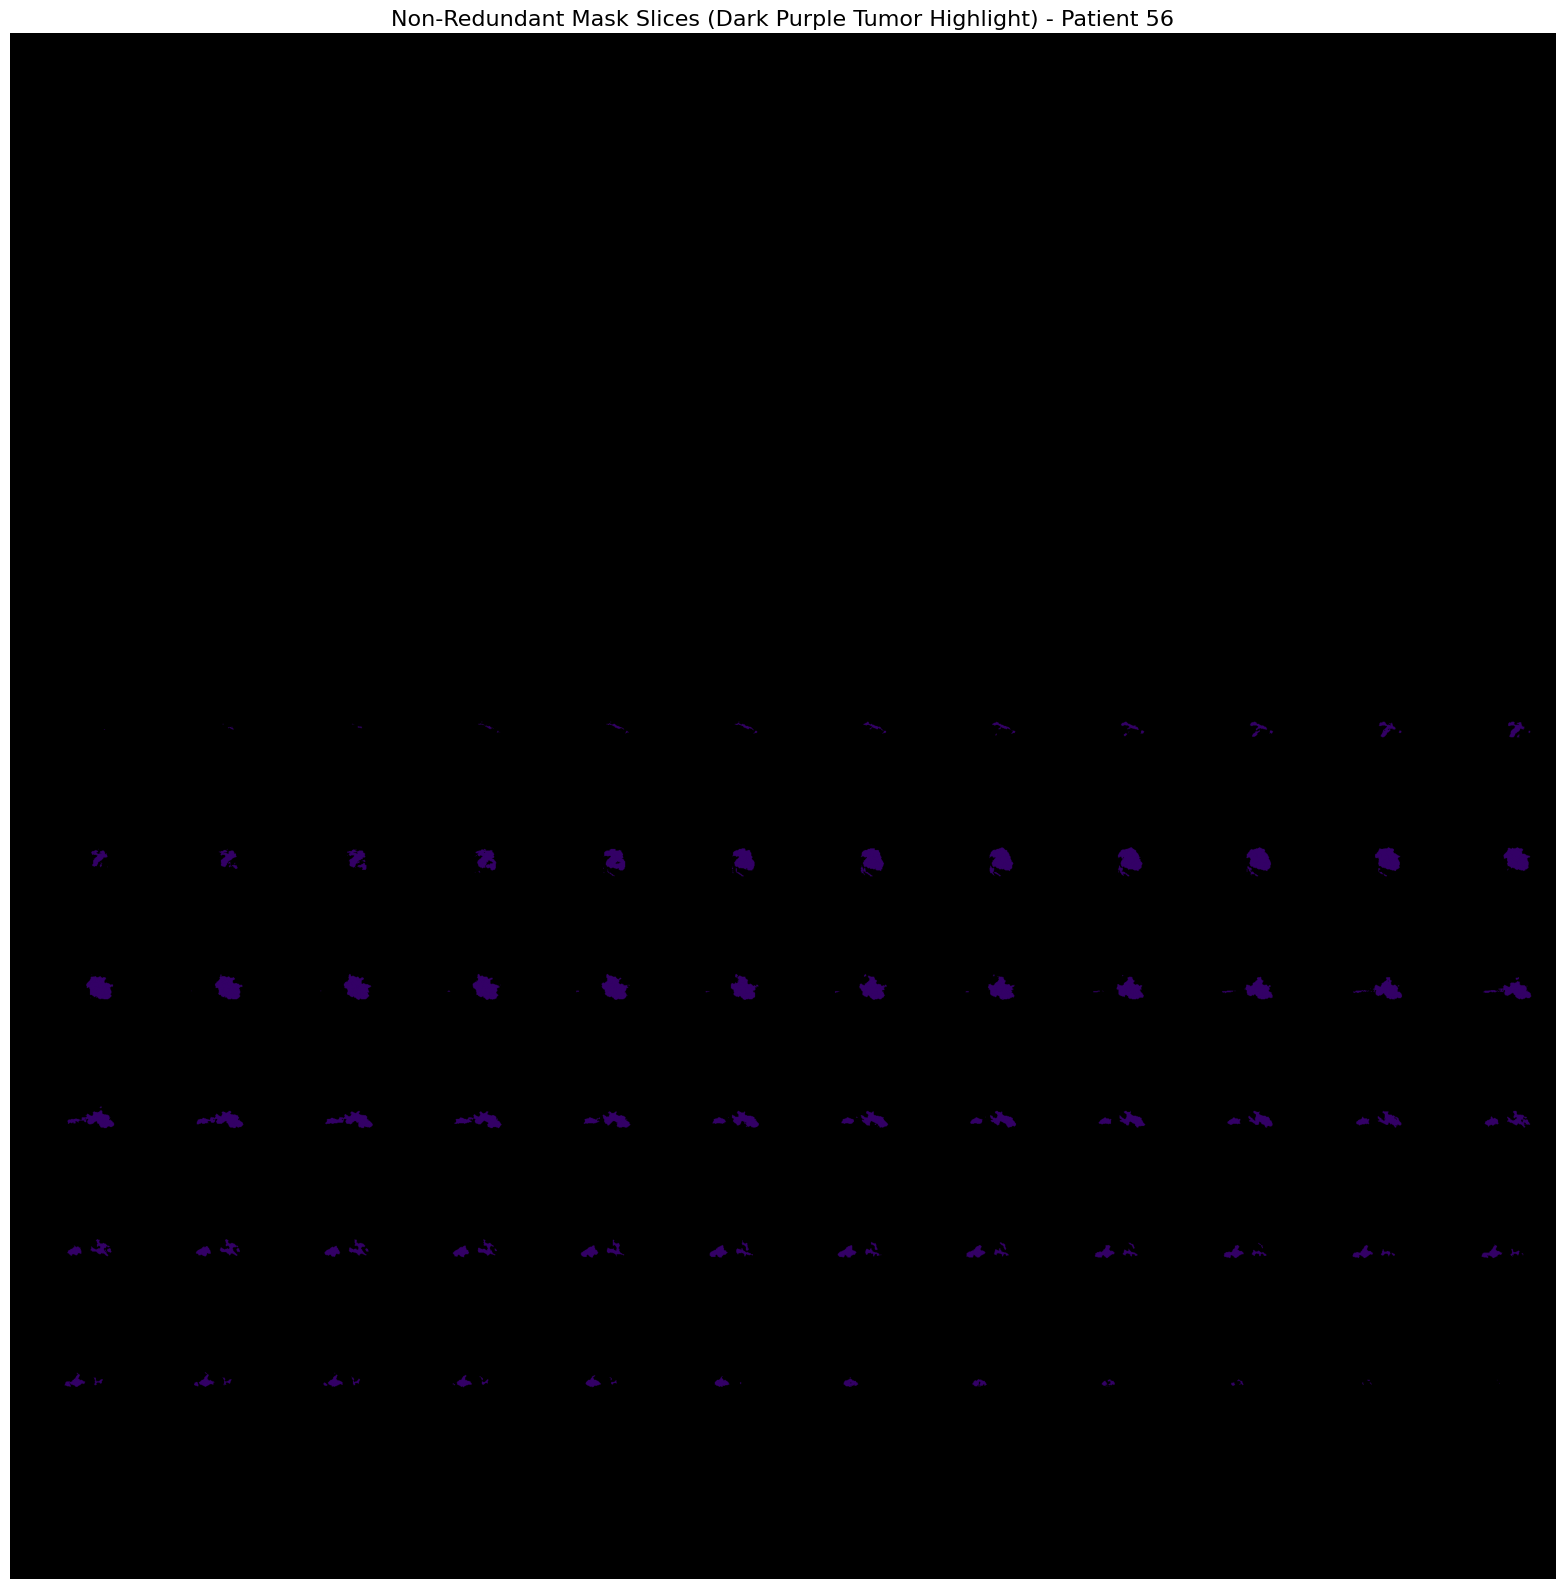

In [48]:
# -----------------------------
# 2. Visualize Non-Redundant T1 Slices
print("Identifying non-redundant slices...")
threshold = 0.01
non_redundant_indices = []
for i in range(SLICES):
    slice_max = np.max(t1_slices[i])
    global_max = np.max(t1_slices)
    if slice_max > threshold * global_max:
        non_redundant_indices.append(i)

print(f"Found {len(non_redundant_indices)} non-redundant slices out of {SLICES}")
print(f"Non-redundant slice indices: {non_redundant_indices[:10]}...{non_redundant_indices[-10:]}")

t1_clean = t1_slices[non_redundant_indices]

# Calculate optimal grid for non-redundant slices
n_clean = len(t1_clean)
grid_cols = min(12, n_clean)
grid_rows = ceil(n_clean / grid_cols)

fig2 = visualize_all_slices_subplot(t1_clean,
                                   f"Non-Redundant T1 Slices ({len(t1_clean)}/{SLICES}) - Patient {patient_id}",
                                   grid_cols=grid_cols)
plt.show()

# Add mask montage for non-redundant slices in dark purple using NIfTI mask
print("Creating mask montage for non-redundant slices...")
mask_montage = np.zeros((n_clean, IMG_HEIGHT, IMG_WIDTH, 3))
for i in range(n_clean):
    mask_onehot = convert_mask_to_onehot(mask_3d, non_redundant_indices[i])
    mask = np.argmax(mask_onehot, axis=-1)
    tumor_mask = np.isin(mask, [1, 2, 3]).astype(np.uint8)  # Combine tumor classes
    highlighted = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))
    highlighted[tumor_mask == 1] = [0.2, 0, 0.4]  # Dark purple for tumor regions
    mask_montage[i] = highlighted
mask_grid = montage(mask_montage, grid_shape=(grid_rows, grid_cols), channel_axis=-1, fill=[0, 0, 0])
plt.figure(figsize=(18, 16))
plt.imshow(mask_grid, aspect='equal')
plt.title(f"Non-Redundant Mask Slices (Dark Purple Tumor Highlight) - Patient {patient_id}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

Fixed slice selection, as implemented in the model code with a range of 110 slices from slice index 22 to 131, provides a consistent approach to training by processing a predetermined number of slices for each patient. This fixed range ensures that all patients contribute a uniform number of slices, starting from slice index 22, which may include both informative slices with tumor content and some redundant ones due to individual anatomical differences and tumor distributions. While this approach simplifies data handling, it may include slices with minimal tumor information (e.g., those dominated by the Background class, 0) and potentially exclude some informative slices outside the defined range (beyond slice 131), affecting training efficiency and accuracy to a degree. By processing the 110 slices within this range, the model allocates computational resources across the specified volume, which can impact training time but ensures comprehensive coverage of the selected patient data.

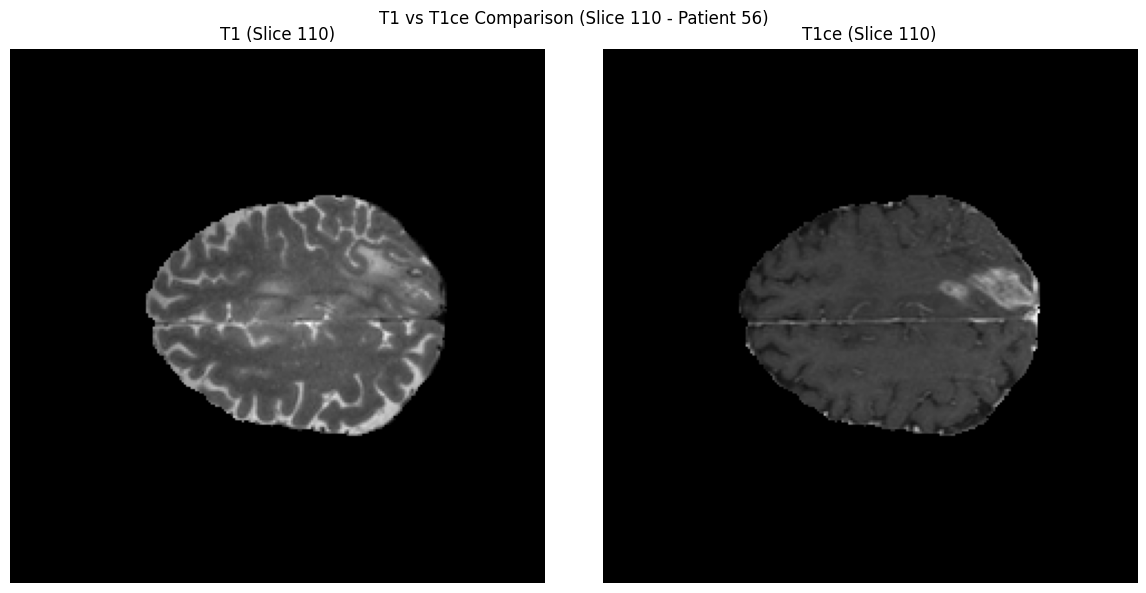

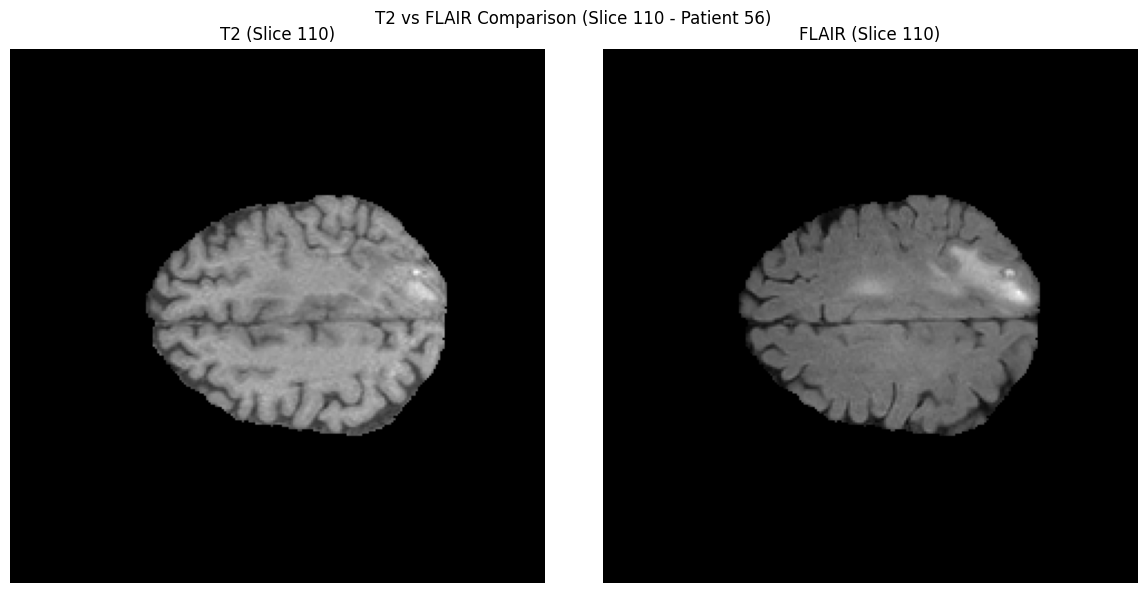

Conclusion:
- T1ce offers better tumor contrast than T1.
- FLAIR provides clearer lesion/edema detection than T2.


In [87]:
# -----------------------------
# 3. Modality Comparison using middle Slice 95
slice_idx = 110 #90

# First show T1 vs T1ce comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
modalities_t1 = ["T1", "T1ce"]
for i, modality in enumerate(modalities_t1):
    slice_data = images[slice_idx, :, :, MODALITY_INDICES[modality]]  # Use correct mapping
    # Normalize for better visualization
    if slice_data.max() > slice_data.min():
        slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())

    axes[i].imshow(slice_data, cmap='gray')
    axes[i].set_title(f"{modality} (Slice {slice_idx})")
    axes[i].axis('off')

plt.suptitle(f"T1 vs T1ce Comparison (Slice {slice_idx} - Patient {patient_id})")
plt.tight_layout()
plt.show()

# Then show T2 vs FLAIR comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
modalities_t2 = ["T2", "FLAIR"]
for i, modality in enumerate(modalities_t2):
    slice_data = images[slice_idx, :, :, MODALITY_INDICES[modality]]  # Use correct mapping
    # Normalize for better visualization
    if slice_data.max() > slice_data.min():
        slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())

    axes[i].imshow(slice_data, cmap='gray')
    axes[i].set_title(f"{modality} (Slice {slice_idx})")
    axes[i].axis('off')

plt.suptitle(f"T2 vs FLAIR Comparison (Slice {slice_idx} - Patient {patient_id})")
plt.tight_layout()
plt.show()

print("Conclusion:")
print("- T1ce offers better tumor contrast than T1.")
print("- FLAIR provides clearer lesion/edema detection than T2.")

***Hence, using only T1ce and FLAIR is sufficient because T1ce enhances tumor boundaries, while FLAIR suppresses normal fluid signals to highlight edema and lesions, providing a balance of accuracy and computational efficiency for segmentation tasks.***


When analyzing brain scans, we use four different imaging techniques, or **modalities**, to get a full picture. Each one highlights different aspects of the brain, which helps doctors detect and diagnose abnormalities.

### **Breakdown of the Four Modalities:**

1. **T1 (Native):** This scan gives a clear view of the brain’s structure, making it useful for spotting things like tumors and cysts.
2. **T1ce (Post-contrast T1-weighted, aka T1Gd):** It’s similar to T1, but with a contrast agent (Gadolinium) that makes abnormalities stand out even more.
3. **T2:** This one focuses on fluids in the brain, which can help in identifying swelling or other issues.
4. **T2-FLAIR (Fluid Attenuated Inversion Recovery):** This scan is like T2, but it suppresses normal fluid signals, making hidden abnormalities (like lesions in white matter) easier to see.

For doctors, using all four modalities gives the most complete picture for diagnosing brain tumors. However, since we’re working with **DRUnet-based segmentation**, using all four is computationally heavy. To make things more efficient, we can **reduce the number of modalities** while still getting reliable results.

### **Why We’re Using Only T1ce & T2-FLAIR**

- We **don’t need T1**, because T1ce (the contrast-enhanced version) already provides a clearer view of tumor boundaries and enhances visibility of abnormal tissue.
- We **skip T2**, since its emphasis on fluids might introduce noise and reduce model accuracy by highlighting non-specific edema signals.
- **T2-FLAIR is a better choice** because it suppresses normal fluid signals, making affected areas like edema and lesions stand out more clearly against the background.
- This selection balances accuracy and efficiency, leveraging T1ce for tumor contrast and FLAIR for lesion detection, which is sufficient for robust segmentation.

By keeping **T1ce and T2-FLAIR**, we strike a balance between accuracy and efficiency, allowing our model to work faster while still making reliable segmentations.

class distribution in slice 110: {np.int64(0): np.int64(56676), np.int64(1): np.int64(38), np.int64(2): np.int64(376), np.int64(3): np.int64(510)}


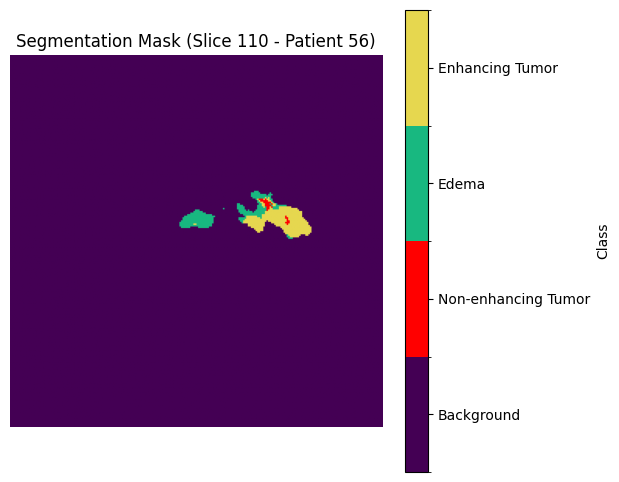

Class 0 (Background-Non Tumor (Class 0)) detected with 56676.0 pixels
Class 1 (Non-enhancing Tumor (Class 1)) detected with 38.0 pixels
Class 2 (Edema (Class 2)) detected with 376.0 pixels
Class 3 (Enhancing Tumor (Class 3)) detected with 510.0 pixels


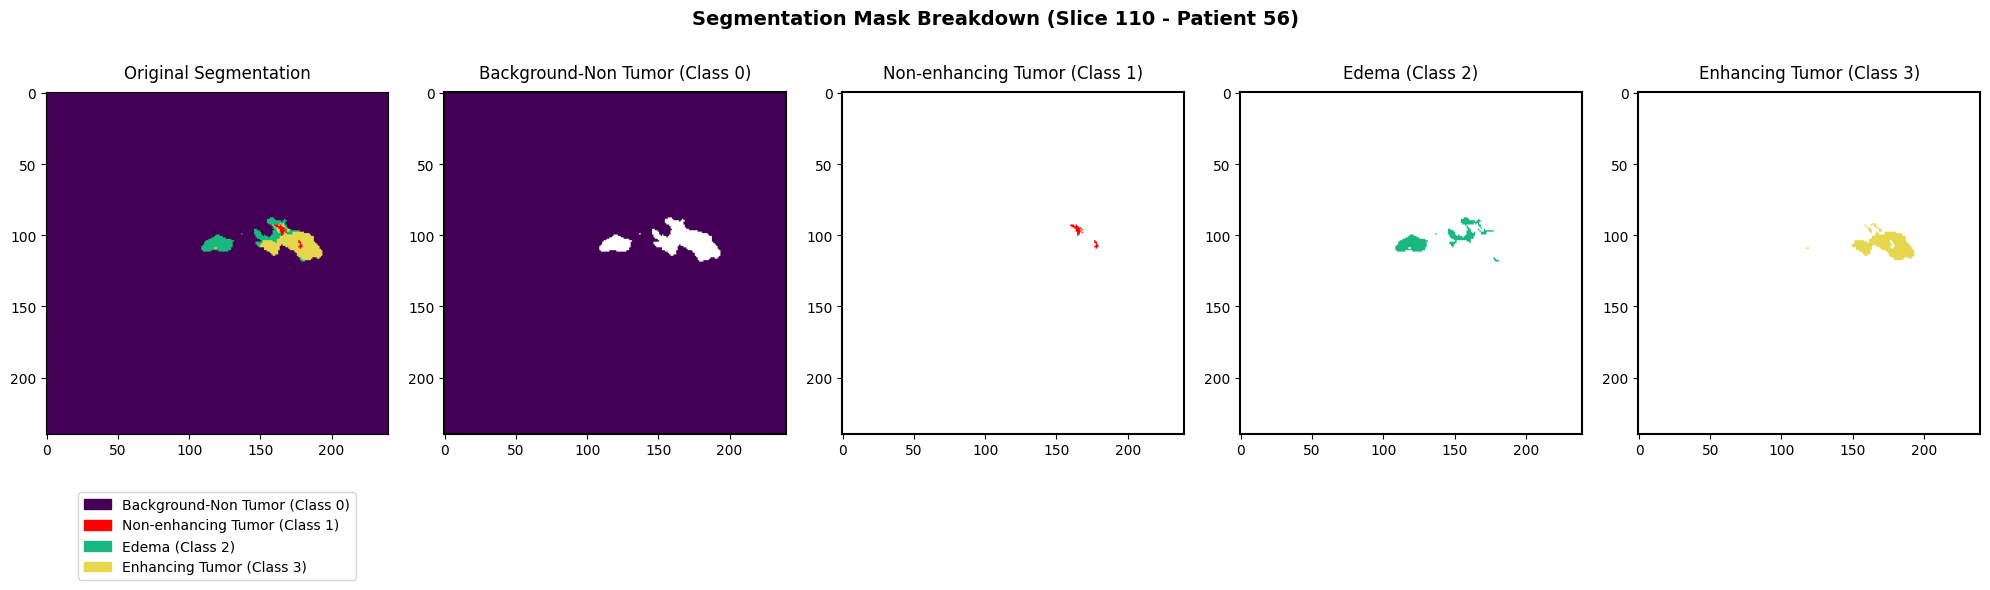

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches

# Assuming you have these variables defined:
# mask_3d, slice_idx, patient_id, CLASS_LABELS, convert_mask_to_onehot()

# -----------------------------
# 1. Single Mask Visualization (like your eee.png)
plt.figure(figsize=(6, 6))
mask_onehot = convert_mask_to_onehot(mask_3d, slice_idx)
mask_display = np.argmax(mask_onehot, axis=-1)

# Use all classes for consistent color coding
colors = ['#440054', '#ff0000', '#18b880', '#e6d74f']
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

img = plt.imshow(mask_display, cmap=cmap, norm=norm)
plt.colorbar(img, label='Class', ticks=[0, 1, 2, 3],
             format=matplotlib.ticker.FixedFormatter(list(CLASS_LABELS.values())))
plt.title(f"Segmentation Mask (Slice {slice_idx} - Patient {patient_id})")
plt.axis('off')

# Print class distribution (like in your eee.png)
mask_flat = mask_display.flatten()
unique, counts = np.unique(mask_flat, return_counts=True)
print(f"class distribution in slice {slice_idx}: {dict(zip(unique, counts))}")

plt.show()

# -----------------------------
# 2. Detailed Breakdown Visualization (with white background for absent tumor classes)
fig, ax = plt.subplots(1, 5, figsize=(20, 5), facecolor='white')

# Define colors and class names
class_names = ['Background-Non Tumor (Class 0)',
               'Non-enhancing Tumor (Class 1)',
               'Edema (Class 2)',
               'Enhancing Tumor (Class 3)']

# 1. Original Segmentation
ax[0].imshow(mask_display, cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation', pad=10, fontsize=12)
ax[0].axis('on')
ax[0].grid(False)

# Print class detection info (like in your eee.png)
for i in range(4):
    class_mask = mask_onehot[:, :, i]
    if np.any(class_mask):
        print(f"Class {i} ({class_names[i]}) detected with {np.sum(class_mask)} pixels")
    else:
        print(f"Class {i} ({class_names[i]}) not detected in slice {slice_idx}")

# Create legend
legend_patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(4)]
ax[0].legend(handles=legend_patches, bbox_to_anchor=(0.5, -0.15),
            loc='upper center', ncol=1, fontsize=10)

# 2-5. Individual Class Breakdowns
for i in range(4):
    class_mask = mask_onehot[:, :, i]
    colored_mask = np.ones((*class_mask.shape, 4))  # White background (RGBA)

    # Special handling for tumor classes (1 and 3)
    if i in [1, 3]:  # Non-enhancing or Enhancing Tumor
        if np.any(class_mask):
            colored_mask[class_mask == 1] = [*matplotlib.colors.to_rgb(colors[i]), 1]
            title_color = 'black'
        else:
            title_color = 'gray'  # Gray title for absent tumor classes
    else:
        # For non-tumor classes (0 and 2), always show the color
        colored_mask[class_mask == 1] = [*matplotlib.colors.to_rgb(colors[i]), 1]
        title_color = 'black'

    ax[i+1].imshow(colored_mask)
    ax[i+1].set_title(class_names[i], pad=10, fontsize=12, color=title_color)
    ax[i+1].axis('on')
    ax[i+1].grid(False)

    for spine in ax[i+1].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

plt.suptitle(f"Segmentation Mask Breakdown (Slice {slice_idx} - Patient {patient_id})", y=1.05, fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

### **Summary of Our Data Exploration**
- **3D Images:** The scans are **3D**, made up of **2D slices** viewed from different planes, with each patient scan including 155 axial slices across 4 modalities (T1, T1CE, T2, and FLAIR) along with a segmentation map showing tumor areas, loaded initially from HDF5 and NIfTI files.
- **Useful Slices:** Not all slices contain meaningful information; we visualized all 155 T1 slices to identify black, redundant parts and selected a fixed range of **110 slices** starting from slice index 22 to index 131, to ensure consistent coverage, avoiding dynamic thresholding based on intensity.
- **Selected Modalities:** We compared T1 vs. T1ce and T2 vs. FLAIR at slice 95, concluding that **T1CE and FLAIR** provide the most useful contrast and anatomical details for efficient segmentation, leading us to use only these two modalities.
- **Segmentation Classes:** The segmented mask breakdown for slice 95 revealed **1 to 4 tumor classes**, with class 4 remapped to class 3 for consistency using NIfTI masks, and the background class (0) was shown to be dominant.
- **Background Class:** To avoid losing important details, we won’t crop the images, preserving the full context of the background class alongside tumor regions.

### **Conclusion**
This EDA confirms the utility of axial slicing for initial tumor analysis, highlights redundant slices in the T1 montage, and supports the use of a fixed range of 110 slices starting from slice index 22 for consistent data coverage. The modality comparison justifies using T1ce and FLAIR for efficient segmentation, while the NIfTI mask integration ensures accurate labeling of segmentation classes. These insights will guide the model’s focus on a standardized dataset for robust performance.